# Hogwarts High
## Collating the British and American version

### Introduction

It is a well-known fact that the Harry Potter novels initially appeared in a so-called British version (UK), which was subsequently edited into an American version (VS). There are at least two intriguing aspects to this:

- Rowling herself worked with her American editor on the US version; thus, she can be said to have "authorized" the changes. Because of this, one could easily claim that the US version should not be considered a mere derivative of a "more original" or "authentic" UK version.
- The changes are relatively frequent and deep: they involve much more than just superficial modifications, e.g. on the level of orthography. Especially, the many (seemingly unnecessary) stylistic interventions are striking and are not always easy to account for on the basis of straightforward cultural differences.

One extremely complicating matter is that the differences between the US and UK versions are not the only differences  that have to be taken into account. Throughout the years, Rowling and her publishers made numerous adaptations to the text, for instance, emendations that corrected obvious mistakes in the plot (consult e.g. [this semi-official list](https://www.hp-lexicon.org/differences-changes-text/)). Although Bloomsbury has published a partial list of the "official" changes by 2004, it is clear that this list is not exhaustive, so that the latest versions contain a curious mix of both "canonical" and "apocryphal" variants. Especially interesting (from the point of view of **stemmatology**, see below), is that some changes were originally made in the US version before making their way into subsequent re-editions of the UK versions. In editorial theory, this phenomenon is known as **contamination**, i.e. the genetic process where initially independent lines of textual offspring start to influence or contaminate each other. This should again raise the awareness that the UK version should necessarily be considered more "original" or "authentic" with respect to the US version -- one cannot easily claim *precedence* over the other.

This makes the study of the Potter variants, official and non-official alike, very convoluted. Powerful mediating institutions, like Amazon for instance, moreover make it surprisingly difficult to retrieve specific (e.g. original) versions of the books, let alone in an electronic format. Recent bibliographic studies on Rowling do not help much in this respect and provide no reasonably detailed "stemma" or genetic tree of the different versions which have been published.

There has been some previous research into the matter, for example, the excellent article by Philip Nel that we use as a basis for this chapter:

> Philip Nel, "You Say 'Jelly,' I Say 'Jell-O'?: Harry Potter and the Transfiguration of Language." *The Ivory Tower and Harry Potter: Perspectives on a Literary Phenomenon*, ed. Lana Whited. Columbia and London: University of Missouri Press, pp. 261-84.

However, while Nel does a great job at inventorizing and interpreting numerous differences between the US and UK version (especially from the point of view of "intralingual, but intercultural translation"), it is clear that he essentially relies on a manual comparison of the books. By necessity, such a laborious exercise must be limited to a small selection or **sample**, compiled during a sustained close reading. For other readers and scholars, it can be hard to assess whether the sample of items is truly representative -- which differences were left out? -- and what the exact criteria for inclusion in the discussion were. Moreover, Nel's analysis is qualitative rather than quantitative and considerations of a more empirical nature are notably absent: we do not get to see which books of the series were more heavily edited than others or which *sort* of edits were more common than others.

### Collation
Here, it is clear that we assume the role of the Devil's advocate in an attempt to introduce the added value which digital methods and distant reading might bring to this debate. We will turn to a popular methodology called **collation** that allows us to provide a higher-level macroanalysis of some the deviations between the US and UK version. Collation, in the context of (digital) literary studies, refers to the process where scholars compare and align different versions of the same text, for instance, for the sake of producing an edition with a **critical apparatus**. A prototypical example where collation is a useful is that of a medieval text that survives in a large number of manuscripts, which all show (subtle) deviations from each other. In such as case, critics might want to reconstruct the **stemma codicum** of the manuscripts, i.e. establishing a family tree that models which books were in all likelihood copied from each other. Especially in earlier times, this was often done using the so-called Lachmannian method, named after its inventor, the nineteenth-century German critic [Karl Lachmann](https://en.wikipedia.org/wiki/Karl_Lachmann). According to this method, it is possible to determine which manuscripts were copied from through each through at the **errors** which they have in common with respect to the original (i.e. the Principle of the Common Errors). While still influential, this view is not entirely uncontested nowadays, partly because it can be difficult for modern readers to determine what exactly constitutes an "error".

Collation has been -- and continues to be -- an important application in Digital Humanities and the advantages of computers for (semi-)automatic tools were acknowledged very early in the field. Traditionally, collation was often carried out in a **pairwise fashion**, where the extant copies of a text were aligned with a so-called **base manuscript**, that would serve as the reliable point of reference for an edition. Nowadays, this setup has become less common in textual scholarship. People often try to postpone the choice for a single base text (the *Urtext*) and instead align multiple versions of a text at the same time. Another shift has been that collation previously mostly happened at the level of individual words (often called 'tokens'), whereas modern scholarship increasingly is interested in character-level alignment.

In this chapter we will:
1. Load a version of the Harry Potter texts in a handy, nested format
2. Look into some very general differences between the US and UK version
3. Use the stand-alone Java tool `Collatex` to perform a simple collation of the opening chapter of the series
4. Manually look into the Levenshtein metric, one influential historic method in alignment studies
4. Turn to Python to expand the scope of our collation, using the Python port of Collatex
5. Establish a simple "ontology" of the sort of edits we find
6. Measure whether the profile of the edits has changed throughout the books.

## Loading the Potter series

In the code block below, we parse a ready-made TEI version of the British and American version of the Harry Potter series into two Python objects, `UK` and `US`:

In [1]:
import glob
from lxml import etree
from collections import OrderedDict

namespaces = {'tei':'http://www.tei-c.org/ns/1.0'}

def load_potter(indir):
    HP = OrderedDict()
    for fn in sorted(glob.glob(indir + '/*.xml')):
        book = etree.parse(fn)
        book_title = book.xpath('//tei:teiHeader//tei:title//text()',
                                namespaces=namespaces)[0]
        print(book_title)
        HP[book_title] = OrderedDict()
        
        for chapter in book.iterfind('.//tei:div', namespaces=namespaces):
            chapter_title = chapter.find('tei:head',
                                namespaces=namespaces).text
            print('   ', chapter_title)
            HP[book_title][chapter_title] = []
            
            for paragraph in chapter.iterfind('.//tei:p', namespaces=namespaces):
                text = ''.join([x for x in paragraph.itertext()])
                HP[book_title][chapter_title].append(text)
    return HP

UK = load_potter('hp_uk_xml')
US = load_potter('hp_us_xml')

Harry Potter and the Philosopher's Stone
    The Boy Who Lived
    The Vanishing Glass
    The Letters from No One
    The Keeper of the Keys
    Diagon Alley
    The Journey from Platform Nine and Three-Quarters
    The Sorting Hat
    The Potions Master
    The Midnight Duel
    Hallowe’en
    Quidditch
    The Mirror of Erised
    Nicolas Flamel
    Norbert the Norwegian Ridgeback
    The Forbidden Forest
    Through the Trapdoor
    The Man with Two Faces
Harry Potter and the Chamber of Secrets
    The Worst Birthday
    Dobby’s Warning
    The Burrow
    At Flourish and Blotts
    The Whomping Willow
    Gilderoy Lockhart
    Mudbloods and Murmurs
    The Deathday Party
    The Writing on the Wall
    The Rogue Bludger
    The Duelling Club
    The Polyjuice Potion
    The Very Secret Diary
    Cornelius Fudge
    Aragog
    The Chamber of Secrets
    The Heir of Slytherin
    Dobby’s Reward
Harry Potter and the Prisoner of Azkaban
    Owl Post
    Aunt Marge’s Big Mistake
    The

Harry Potter and the Deathly Hallows
    THE DARK LORD ASCENDING
    IN MEMORIAM
    THE DURSLEYS DEPARTING
    THE SEVEN POTTERS
    FALLEN WARRIOR
    THE GHOUL IN PAJAMAS
    THE WILL OF ALBUS DUMBLEDORE
    THE WEDDING
    A PLACE TO HIDE
    KREACHER'S TALE
    THE BRIBE
    MAGIC IS MIGHT
    THE MUGGLE-BORN REGISTRATION COMMISSION
    THE THIEF
    THE GOBLIN'S REVENGE
    GODRIC'S HOLLOW
    BATHILDA'S SECRET
    THE LIFE AND LIES OF ALBUS DUMBLEDORE
    THE SILVER DOE
    XENOPHILIUS LOVEGOOD
    THE TALE OF THE THREE BROTHERS
    THE DEATHLY HALLOWS
    MALFOY MANOR
    THE WANDMAKER
    SHELL COTTAGE
    GRINGOTTS
    THE FINAL HIDING PLACE
    THE MISSING MIRROR
    THE LOST DIADEM
    THE SACKING OF SEVERUS SNAPE
    THE BATTLE OF HOGWARTS
    THE ELDER WAND
    THE PRINCE'S TALE
    THE FOREST AGAIN
    KING'S CROSS
    THE FLAW IN THE PLAN
    NINETEEN YEARS LATER


`UK` and `US` are *nested* Python objects of the type `OrderedDict`:

In [2]:
print(type(UK))
print(type(US))

<class 'collections.OrderedDict'>
<class 'collections.OrderedDict'>


This is a special kind of dictionary in which the keys do have an order, unlike the traditional or default dictionaries in Python. (We still make a big deal out of this here, but starting from Python 3.6 *all* Python dictionaries have in fact become ordered, meaning that they the remember the order in which keys were added to it.) An `OrderedDict` still has keys like a normal `dict` that can be used to retrieve values from it:

In [3]:
print(UK.keys())
print(US.keys())

odict_keys(["Harry Potter and the Philosopher's Stone", 'Harry Potter and the Chamber of Secrets', 'Harry Potter and the Prisoner of Azkaban', 'Harry Potter and the Goblet of Fire', 'Harry Potter and the Order of the Phoenix', 'Harry Potter and the Half Blood Prince', 'Harry Potter and the Deathly Hallows'])
odict_keys(["Harry Potter and the Sorcerer's Stone", 'Harry Potter and the Chamber of Secrets', 'Harry Potter and the Prisoner of Azkaban', 'Harry Potter and the Goblet of Fire', 'Harry Potter and the Order of the Phoenix', 'Harry Potter and the Half-Blood Prince', 'Harry Potter and the Deathly Hallows'])


As you can see, at the highest tier, `UK` and `US` contain a list of the titles of the individual books in the series in chronological order, so that they can be easily aligned -- i.e. the third title in `UK` corresponds to the third title in `US`. We can now retrieve the type (`type()`) and length (`len()`) value which has been stored for one of these individual titles:

In [4]:
goblet = US["Harry Potter and the Goblet of Fire"]
print(type(goblet))

<class 'collections.OrderedDict'>


At the next tier in our objects, we see that for each each title, we have stored an additional `OrderedDict`. As can be gleaned from their length and keys, this is where we store the consecutive chapters contained in an book:

In [5]:
print(len(goblet))
print(goblet.keys())

37
odict_keys(['THE RIDDLE HOUSE', 'THE SCAR', 'THE INVITATION', 'BACK TO THE BURROW', "WEASLEYS' WIZARD WHEEZES", 'THE PORTKEY', 'BAGMAN AND CROUCH', 'THE QUIDDITCH WORLD CUP', 'THE DARK MARK', 'MAYHEM AT THE MINISTRY', 'ABOARD THE HOGWARTS EXPRESS', 'THE TRIWIZARD TOURNAMENT', 'MAD-EYE MOODY', 'THE UNFORGIVABLE CURSES', 'BEAUXBATONS AND DURMSTRANG', 'THE GOBLET OF FIRE', 'THE FOUR CHAMPIONS', 'THE WEIGHING OF THE WANDS', 'THE HUNGARIAN HORNTAIL', 'THE FIRST TASK', 'THE HOUSE-ELF LIBERATION FRONT', 'THE UNEXPECTED TASK', 'THE YULE BALL', "RITA SKEETER'S SCOOP", 'THE EGG AND THE EYE', 'THE SECOND TASK', 'PADFOOT RETURNS', 'THE MADNESS OF MR. CROUCH', 'THE DREAM', 'THE PENSIEVE', 'THE THIRD TASK', 'FLESH, BLOOD, AND BONE', 'THE DEATH EATERS', 'PRIORI INCANTATEM', 'VERITASERUM', 'THE PARTING OF THE WAYS', 'THE BEGINNING'])


If we drill our way further down this hierarchical structure, we can now inspect what each chapter contains:

In [6]:
scar = goblet['THE SCAR']
print(type(scar))
print(len(scar))

<class 'list'>
36


As you can see, each chapter is represented by a list, finally, which contains a the list of the "paragraphs" -- or rather, text blocks -- in the chapter. We can print a random paragraph:

In [7]:
p = scar[3]
print(p)

Harry tried to recall what he had been dreaming about before he had awoken. It had seemed so real. . . . There had been two people he knew and one he didn’t. . . . He concentrated hard, frowning, trying to remember. . . .


To conclude, our `UK` and `US` objects offer a multi-tiered or nested data structure for the American and British books in de the series, storing for each book title a series of chapter, which in turn contain a list of paragraphs for each chapter. Accessing one of the paragraphs, goes through **stacking indexes** on top op each other, like so:

In [8]:
print(US['Harry Potter and the Goblet of Fire']['BACK TO THE BURROW'][6])
print(UK['Harry Potter and the Deathly Hallows']['Magic is Might'][-1])
print(US['Harry Potter and the Chamber of Secrets']['THE VERY SECRET DIARY'][0])

“They’ll be driving, of course?” Uncle Vernon barked across the table.
The golden grilles slid apart again and Hermione gasped. Four people stood before them, two of them deep in conversation: a long-haired wizard wearing magnificent robes of black and gold and a squat, toad-like witch wearing a velvet bow in her short hair and clutching a clipboard to her chest.
Hermione remained in the hospital wing for several weeks. There was a flurry of rumor about her disappearance when the rest of the school arrived back from their Christmas holidays, because of course everyone thought that she had been attacked. So many students filed past the hospital wing trying to catch a glimpse of her that Madam Pomfrey took out her curtains again and placed them around Hermione’s bed, to spare her the shame of being seen with a furry face.


To obtain the whole text of a chapter, we simply join the respective paragraphs for that chapter using a whitespace character:

In [9]:
chap = ' '.join(UK['Harry Potter and the Deathly Hallows']['Magic is Might'])
print(chap[:1000] + '[...]')

As August wore on, the square of unkempt grass in the middle of Grimmauld Place shrivelled in the sun until it was brittle and brown. The inhabitants of number twelve were never seen by anybody in the surrounding houses, and nor was number twelve itself. The Muggles who lived in Grimmauld Place had long since accepted the amusing mistake in the numbering that had caused number eleven to sit beside number thirteen. And yet the square was now attracting a trickle of visitors who seemed to find the anomaly most intriguing. Barely a day passed without one or two people arriving in Grimmauld Place with no other purpose, or so it seemed, than to lean against the railings facing numbers eleven and thirteen, watching the join between the two houses. The lurkers were never the same two days running, although they all seemed to share a dislike for normal clothing. Most of the Londoners who passed them were used to eccentric dressers and took little notice, though occasionally one of them might g

#### Exercise
> Print the last 500 characters of the pentultimate chapter in *Harry Potter and the Half-Blood Prince*.

In [10]:
# your exercise code goes here

## General statistics

Now that we have loaded the Harry Potter texts into our notebooks, we can already make some exploratory, high-level plots of the book series. When looking at the Harry Potter series in a book store, for instance, it is clear that Rowling's books seem to have become longer:

![alt text](http://ecx.images-amazon.com/images/I/51BRMauPcNL.jpg "Logo Title Text 1")

Let us warm through making some simple plots that help us verify this impressions. For this this we make use of an established plotting library in Python, called `matplotlib`, which we import using the **alias** `plt`. To make sure that everything gets displayed correctly, and in a pleasing style, in our notebook, we first need to execute the block below.

In [11]:
%matplotlib inline
import matplotlib.style
matplotlib.style.use('seaborn-deep')
import matplotlib.pyplot as plt

The easiest way to measure the length of a book is to simply count the total number of characters it contains. For the UK books, for instance, we can first loop over the books in `UK`, then over the chapter and then over the paragraphs. For each book, we keep track of the number of characters it contains in a list of integers which we call `uk_len`:

In [12]:
uk_len = []

for uk_book in UK:
    
    uk_cnt = 0
    for uk_chap in UK[uk_book]:
        uk_text = ' '.join(UK[uk_book][uk_chap])
        uk_cnt += len(uk_text)
    
    uk_len.append(uk_cnt)

print(uk_len)

[492819, 482916, 610797, 1073925, 1455177, 968564, 1103344]


From these numbers, it becomes clear already that the Harry Potter books, at least in the UK version, have grown significantly longer. We can now draw a block to visualize this information. Most of the commands used below should be intuitive enough to make sense to you (e.g. adding a legend and axis labels etc.).

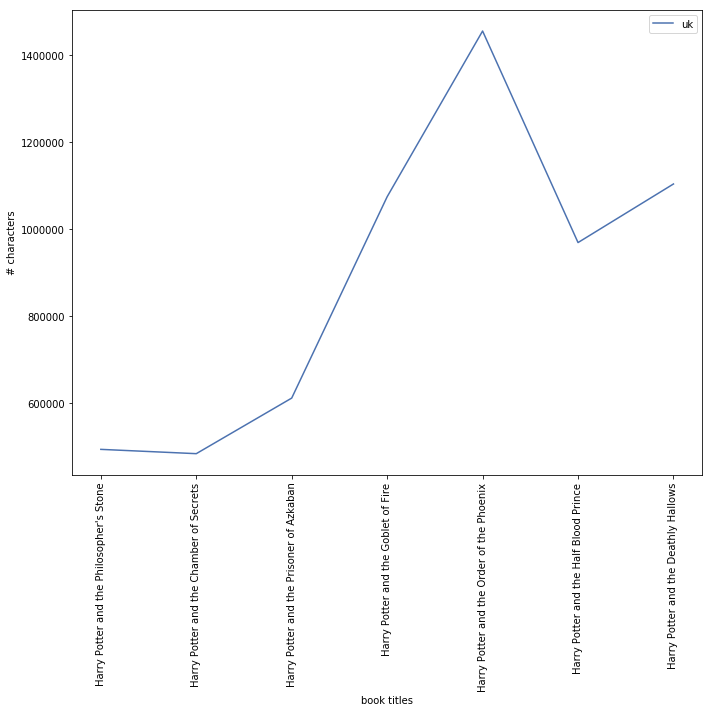

In [13]:
plt.figure(figsize=(10, 10))
plt.plot(uk_len, label='uk')
plt.ylabel('# characters')
plt.xlabel('book titles')
plt.xticks(range(len(uk_len)), UK.keys(), rotation='vertical')
plt.legend()
plt.tight_layout()

This simple **line plot** visually confirms our expectation: ever since the relatively shorter *Philosopher's Stone*, the books have grown considerably larger. Although the *Half-Blood Prince* somewhat countered this trend, the finale of the series grows longer again - and both concluding volumes are clearly longer than the opening three items in the series. The fourth item, the *Phoenix* reaches the maximum length -- and, as will we see later, this is not the only respect in which the *Phoenix* seems to play an exceptional role in the development of the series. Funnily, Rowling recently tweeted that in her *Cormoran Strike* series too, the "fourth book" would be the longest there as well:

<blockquote class="twitter-tweet" data-lang="en"><p lang="en" dir="ltr">It progresses. Turns out the fourth in every one of my series has to be the longest. 🙄 <a href="https://t.co/cnXl2Qju6Y">https://t.co/cnXl2Qju6Y</a></p>&mdash; J.K. Rowling (@jk_rowling) <a href="https://twitter.com/jk_rowling/status/958376528643002370?ref_src=twsrc%5Etfw">January 30, 2018</a></blockquote>
<script async src="https://platform.twitter.com/widgets.js" charset="utf-8"></script>

Funnily, according to our numbers, the fourth book in the Harry Potter series does have the largest number of chapters, but it was *not* the longest in terms of length in characters...

Literary scholars might easily interpret this development in terms of Rowling's growing success: ever since her books became international bestsellers, she must have obtained more leeway and artistic freedom with her editors, allowing her to create longer books, since the publisher could trust on the success of the upcoming items in the series. This is also evident from the number of chapters contained in the book. Using a simple **list comprehension** we retrieve the length of each book in terms of the number of chapters it contains. (For now, you can just think of a list comprehension as a `for` loop that gets written on a single line.)

In [14]:
chap_len = [len(UK[t]) for t in UK]
print(chap_len)

[17, 18, 22, 37, 38, 30, 37]


Plotting this information requires only minor adjustments to our previous plotting block. Can you see which bits we had to change?

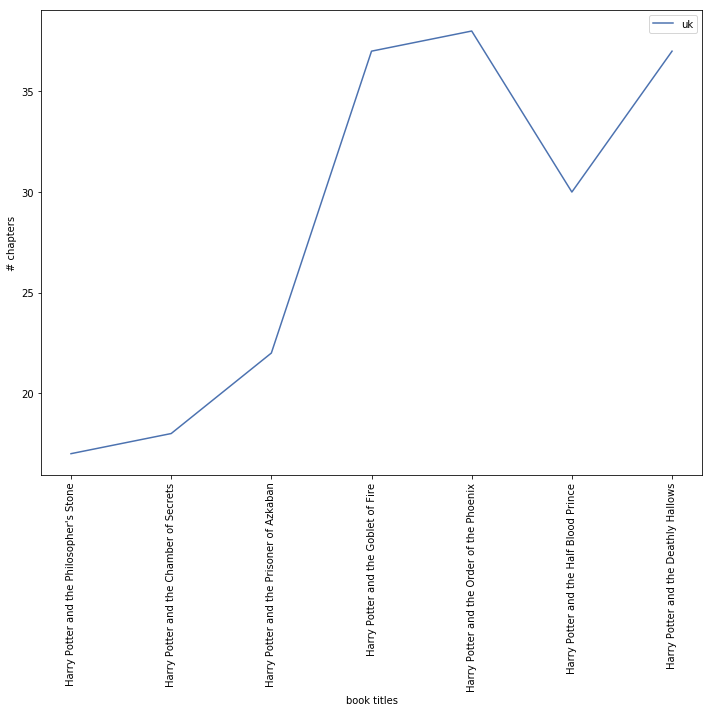

In [15]:
plt.figure(figsize=(10, 10))
plt.plot(chap_len, label='uk')
plt.ylabel('# chapters')
plt.xlabel('book titles')
plt.xticks(range(len(chap_len)), UK.keys(), rotation='vertical')
plt.legend()
plt.tight_layout()

Here, it is interesting how the evolution of the number of chapter per books closely parallels the overall length of the books -- which makes sense intuitively, at least if we assume that the average length of a chapter did not change radically.

#### Quiz
> Create the same plots (length of the books in characters and chapters), but now for the US version.

## Sentence length

**Readability** is a thorny issue in the international Rowling criticism, especially in the context of the difference between the UK and US versions. Reviewers, critics and readers alike have noted that many aspects of the US version seem to have been somewhat "simplified" in comparison to the UK version. Some critics have gone as far as claiming that this would constitute a pure act of "dumbing down" the books for a less intellectual American readership. Others might counter this naive view by arguing that such interventions might actually boost the stylistic qualities of the books. One crude, yet insightful way to quantify such differences would be to inspect the average length of sentences in the books. Would the length of sentences (i.e. the number of word tokens they contain), on average, indeed be shorter in the UK than in the US version?

For this, we need a so-called **sentence splitter**: to a computer the piece of text contained in our paragraphs is just a series of characters, the primitive **string** data type. Outfront, our computer has no idea where a single sentence starts and another might begin. Inspect, for instance, the very first paragraph in the series:

In [16]:
p = UK["Harry Potter and the Philosopher's Stone"]['The Boy Who Lived'][0]
print(p)


     Mr and Mrs Dursley, of number four, Privet Drive, were proud to say that
      they were perfectly normal, thank you very much. They were the last people you’d expect to be
      involved in anything strange or mysterious, because they just didn’t hold with such
      nonsense.
    


Here, it obvious that we are in fact dealing with two sentences. To calculate the average length of a sentence, we first need to segment these sentences first. To this end we can import the ready-made `sent_tokenize` function that ships with `nltk` (Natural Language Toolkit); this is a language processing library that is commonly used in Python. If we feed this function our paragraph, we can see that it will return a list of strings with the segmented sentences:

In [17]:
from nltk.tokenize import sent_tokenize
sentences = sent_tokenize(p)
print(sentences)

['\n     Mr and Mrs Dursley, of number four, Privet Drive, were proud to say that\n      they were perfectly normal, thank you very much.', 'They were the last people you’d expect to be\n      involved in anything strange or mysterious, because they just didn’t hold with such\n      nonsense.']


As a next step, we could also split those sentences into strings containing individual words -- or **tokens** as they are more commonly called in **Natural Language Processing** (NLP). Nltk has a simple `word_tokenize` function for exactly that too:

In [18]:
from nltk.tokenize import word_tokenize
first = sentences[0]
tokens = word_tokenize(first)
print(tokens)

['Mr', 'and', 'Mrs', 'Dursley', ',', 'of', 'number', 'four', ',', 'Privet', 'Drive', ',', 'were', 'proud', 'to', 'say', 'that', 'they', 'were', 'perfectly', 'normal', ',', 'thank', 'you', 'very', 'much', '.']


If we glue these components together, we are now ready to verify whether the UK and US versions indeed deviate significantly from each other in terms of the average number of words used in a sentence. Using the `zip` function below, we now loop over the books and chapter in the UK and US version simultaneously. (Note, of course, that the number of chapters have never changed in the UK and US version.) Using the `mean` function, from the `statistics` module in Python's **standard library**, we collect for each book its average sentence length.

In [19]:
from statistics import mean

uk_len, us_len, uk_titles  = [], [], []

for uk_book, us_book in zip(UK, US):
    print(uk_book, 'vs', us_book)
    uk_titles.append(us_book)
    
    uk_cnt, us_cnt = [], []
    for uk_chap, us_chap in zip(UK[uk_book], US[us_book]):
        uk_text = ' '.join(UK[uk_book][uk_chap])
        us_text = ' '.join(US[us_book][us_chap])
        
        us_text = us_text.replace('. . .', '.')
        
        uk_sents = sent_tokenize(uk_text)
        us_sents = sent_tokenize(us_text)
        
        uk_cnt.extend(len(word_tokenize(s)) for s in uk_sents)
        us_cnt.extend(len(word_tokenize(s)) for s in us_sents)
    
    # now average at chapter level
    uk_len.append(mean(uk_cnt))
    us_len.append(mean(us_cnt))

print(uk_len)
print(us_len)

Harry Potter and the Philosopher's Stone vs Harry Potter and the Sorcerer's Stone
Harry Potter and the Chamber of Secrets vs Harry Potter and the Chamber of Secrets
Harry Potter and the Prisoner of Azkaban vs Harry Potter and the Prisoner of Azkaban
Harry Potter and the Goblet of Fire vs Harry Potter and the Goblet of Fire
Harry Potter and the Order of the Phoenix vs Harry Potter and the Order of the Phoenix
Harry Potter and the Half Blood Prince vs Harry Potter and the Half-Blood Prince
Harry Potter and the Deathly Hallows vs Harry Potter and the Deathly Hallows
[20.462268041237113, 21.53703341801837, 21.423884715621647, 23.740737119953074, 26.60935976600585, 26.84314208323073, 24.725787284610814]
[19.57976424361493, 20.028044146915143, 18.475418478977197, 19.649271844660195, 22.849349384176467, 22.740270551508846, 22.112815964523282]


Plotting the numbers is very similar to what we have done before, only now, you can see that we call the `plot` function twice, to add a line in the plot for both the `UK` and `US` series.

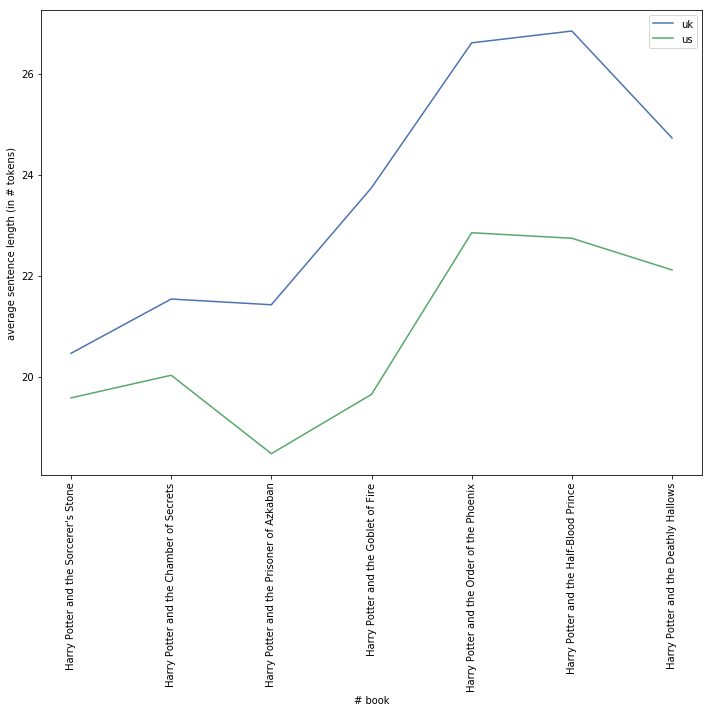

In [20]:
plt.figure(figsize=(10, 10))
plt.plot(uk_len, label='uk')
plt.plot(us_len, label='us')
plt.ylabel('average sentence length (in # tokens)')
plt.xlabel('# book')
plt.xticks(range(len(uk_titles)), uk_titles, rotation='vertical')
plt.legend()
plt.tight_layout()

The difference is striking: we can indeed observe that the US sentences *in each book* are a good deal shorter on average than their British counterparts. This difference grows even more pronounced in the later and longer books, where the US editors (and Rowling herself, apparently) seem to have felt an even stronger need to cut down on the average sentence length. While this is a worthwhile observation in itself, we will come back to a more advanced analysis of this phenomenon in the subsequent sections of this chapter.

## Collation

So far, we have been relying on fairly crude and superficial metrics to compare the UK and US versions, e.g. average sentence length. This is indeed typical of much DH/DLS research, where scholars adopt a **distant or macroanalytical perspective** -- "dumb down, to scale up", so to speak. In the next section, however, we turn to a methodology that allows us to zoom in again on the text, in order to get a grasp of the *actual* microlevel differences that exist between both versions: (semi-)automatic collation. Let us start with a simple example and collate the first chapters of the UK and US version respectively. For this we can make use of an external Java tool called [Collatex](https://collatex.net/), which is one of the more popular tools which are available for aligning and collating multiple (>=2) versions of the same text. This tool comes as single jar-file that you can download from the project's [website](https://collatex.net/) -- we used 1.7.1. (You can place in the same folder as this notebook.) Running this jar-file requires that you have a recent version of the Java programming language: if you don't (know whether you) have that, it's a good idea to download the correct version for your operating system [here](http://www.oracle.com/technetwork/java/javase/downloads/jdk8-downloads-2133151.html).

First, we will use `Collatex` from the command line, which is at this point still the most powerful and flexible interface to the software. For this, you can open a new command line window and type in the commands below. Alternatively, you can just run the commands in the code blocks below -- through adding an exclamation mark (`!`) we indicate that those commands should be executed in the notebook as if we executed them in the shell. (If you do this from the notebook, however, please be well aware that we are no longer working in simple Python here, but that we switch to shell syntax!)

Below, we start by invoking the **help** or **documentation** for the jar-file, which will tell us, amongst others, what sort of input is expected from our side and which settings we can tweak. Some notes on the syntax of this command:
- `java` indicates that we want to run the program using the Java programming language
- `-jar` is a flag indicating that we run a (fully self-contained) jar-version of the Java program
- `collatex-tools-1.7.1.jar` is just the (relative) path to the actual jar file on our system
- `-h` is a flag that we use to print out the help documentation that comes with the jar

In [21]:
!java -jar collatex-tools-1.7.1.jar -h

usage: collatex [<options>]
                (<json_input> | <witness_1> <witness_2> [[<witness_3>] ...])
  -a,--algorithm <arg>                    progressive alignment algorithm to
                                          use 'dekker' (default), 'medite',
                                          'needleman-wunsch'
  -cp,--context-path <arg>                URL base/context path of the
                                          service, default: '/'
  -dot,--dot-path <arg>                   path to Graphviz 'dot',
                                          auto-detected by default
  -f,--format <arg>                       result/output format: 'json', 'csv',
                                          'dot', 'graphml', 'tei'
  -h,--help                               print usage instructions
  -ie,--input-encoding <arg>              charset to use for decoding non-XML
                                          witnesses; default: UTF-8
  -mcs,--max-collation-size <arg>         maximum numbe

Running the program with the `-h` flag, returns a list of all the possible flags that we can use and their anticipated behavior or effect on the internal working of the tool -- this includes the documentation `-h` and `--help` flags themselves, as you can see. Most of these flags have so-called `default settings`, which means that, if we are happy with them, we do not have to explicitly set them each time we run the program.

Let us first dump a simple plain text version of the first chapters in both the UK and US version. In Python, this is as simple as:

In [22]:
with open('uk_chap1.txt', 'w') as f:
    text = ' '.join(UK["Harry Potter and the Philosopher's Stone"]['The Boy Who Lived'])
    f.write(text)

with open('us_chap1.txt', 'w') as f:
    text = ' '.join(US["Harry Potter and the Sorcerer's Stone"]['THE BOY WHO LIVED'])
    f.write(text)

If you inspect the contents of these newly created files in your text editor, you should see that they contain simple plain text. To now go and collate these texts, we can just add them as additional arguments.

In [23]:
!java -jar collatex-tools-1.7.1.jar uk_chap1.txt us_chap1.txt

{"witnesses":["w1","w2"],"table":[[["Mr "],["Mr"]],[[],[". "]],[["and ","Mrs "],["and ","Mrs"]],[[],[". "]],[["Dursley",", ","of ","number ","four",", ","Privet ","Drive",", ","were ","proud ","to ","say ","that\n      ","they ","were ","perfectly ","normal",", ","thank ","you ","very ","much",". ","They ","were ","the ","last ","people ","you’d ","expect ","to ","be\n      ","involved ","in ","anything ","strange ","or ","mysterious",", ","because ","they ","just ","didn’t ","hold ","with ","such\n      ","nonsense",".\n     \n     ","Mr "],["Dursley",", ","of ","number ","four",", ","Privet ","Drive",", ","were ","proud ","to ","say ","that ","they ","were ","perfectly ","normal",", ","thank ","you ","very ","much",". ","They ","were ","the ","last ","people ","you’d ","expect ","to ","be ","involved ","in ","anything ","strange ","or ","mysterious",", ","because ","they ","just ","didn’t ","hold ","with ","such ","nonsense",". ","Mr"]],[[],[". "]],[["Dursley ","was ","the ","directo

He ","was ","rattled",". ","He\n      ","hurried ","to ","his ","car ","and ","set ","off "],["Dursley ","stood ","rooted ","to ","the ","spot",". ","He ","had ","been ","hugged ","by ","a ","complete ","stranger",". ","He ","also ","thought ","he ","had ","been ","called ","a ","Muggle",", ","whatever ","that ","was",". ","He ","was ","rattled",". ","He ","hurried ","to ","his ","car ","and ","set ","off "]],[[],["for "]],[["home",", ","hoping ","he ","was ","imagining ","things",", ","which ","he ","had ","never ","hoped\n      ","before",", ","because ","he ","didn’t ","approve ","of ","imagination",".\n     \n     ","As ","he ","pulled ","into ","the ","driveway ","of ","number ","four",", ","the ","first ","thing ","he ","saw "],["home",", ","hoping ","he ","was ","imagining ","things",", ","which ","he ","had ","never ","hoped ","before",", ","because ","he ","didn’t ","approve ","of ","imagination",". ","As ","he ","pulled ","into ","the ","driveway ","of ","number ","four",", "

 ","the ","wall ","outside ","was ","showing ","no ","sign ","of ","sleepiness",". ","It ","was ","sitting ","as ","still ","as ","a ","statue",", ","its\n      ","eyes ","fixed ","unblinkingly ","on ","the ","far ","corner ","of ","Privet ","Drive",". ","It ","didn’t ","so ","much ","as ","quiver ","when ","a\n      ","car ","door ","slammed "],["Dursley ","might ","have ","been ","drifting ","into ","an ","uneasy ","sleep",", ","but ","the ","cat ","on ","the ","wall ","outside ","was ","showing ","no ","sign ","of ","sleepiness",". ","It ","was ","sitting ","as ","still ","as ","a ","statue",", ","its ","eyes ","fixed ","unblinkingly ","on ","the ","far ","corner ","of ","Privet ","Drive",". ","It ","didn’t ","so ","much ","as ","quiver ","when ","a ","car ","door ","slammed "]],[["in "],["on "]],[["the ","next ","street",", ","nor ","when ","two ","owls ","swooped ","overhead",". ","In ","fact",", ","it ","was\n      ","nearly ","midnight ","before ","the ","cat ","moved ","at ","a

n’t ","kill ","Harry ","Potter",", ","Voldemort’s ","power ","somehow ","broke "],["he ","couldn’t",". ","He ","couldn’t ","kill ","that ","little ","boy",". ","No ","one ","knows ","why",", ","or ","how",", ","but ","they’re ","saying ","that ","when ","he ","couldn’t ","kill ","Harry ","Potter",", ","Voldemort’s ","power ","somehow ","broke "]],[["– "],["— "]],[["and\n      ","that’s ","why ","he’s ","gone","."],["and ","that’s ","why ","he’s ","gone","."]],[["’\n     \n     "],["” "]],[["Dumbledore ","nodded ","glumly",".\n     \n     "],["Dumbledore ","nodded ","glumly",". "]],[["‘It’s ","– "],["“It’s ","— "]],[["it’s ","true","?"],["it’s ","true","?"]],[["’ \n     "],["” "]],[["faltered ","Professor ","McGonagall",". \n     "],["faltered ","Professor ","McGonagall",". "]],[["‘After "],["“After "]],[["all ","he’s ","done "],["all ","he’s ","done "]],[["… "],[". ",". ",". "]],[["all ","the ","people ","he’s ","killed "],["all ","the ","people ","he’s ","killed "]],[["… "],[". ",". "

],["to ","him",", ","sir","?"]],[["’ \n     "],["” "]],[["asked ","Hagrid",".\n     \n     ","He ","bent ","his ","great",", ","shaggy ","head ","over ","Harry ","and ","gave ","him ","what ","must ","have ","been\n      ","a ","very ","scratchy",", ","whiskery ","kiss",". ","Then",", ","suddenly",", ","Hagrid ","let ","out ","a ","howl ","like ","a ","wounded\n      ","dog",".\n     \n     "],["asked ","Hagrid",". ","He ","bent ","his ","great",", ","shaggy ","head ","over ","Harry ","and ","gave ","him ","what ","must ","have ","been ","a ","very ","scratchy",", ","whiskery ","kiss",". ","Then",", ","suddenly",", ","Hagrid ","let ","out ","a ","howl ","like ","a ","wounded ","dog",". "]],[["‘Shhh"],["“Shhh"]],[["!"],["!"]],[["’ \n     "],["” "]],[["hissed ","Professor ","McGonagall"],["hissed ","Professor ","McGonagall"]],[[". \n     ","‘You’ll "],[", ","“you’ll "]],[["wake ","the ","Muggles","!"],["wake ","the ","Muggles","!"]],[["’\n     \n     ","‘S-s-sorry"],["” ","“S-s-sorry"]],

This should print a rather large string to your console: because we did not specify an output file, the output of the program simply gets passed to the command line (or the so-called **standard output** route) in its entirety. To catch this output and send it to an actual file, there is a again a useful flag for this:

In [24]:
!java -jar collatex-tools-1.7.1.jar uk_chap1.txt us_chap1.txt --output chap1.json

If you open the resulting file in a text editor, you will see that the output in the file `chap1.json` has been formatted as **json**. As you can see, json is a format that allows to express a number of simple data structures using a structure that is reminiscent of the way lists or dictionaries are created in Python. For now, have a look at the bit that follows `"table":`. Can you explain how the result of the collation of two **witnesses** or text versions is reflected in this data structure?

## The Python port

Since a couple of years, there exists also a sort of rewrite or **port** of Collatex to Python and we will now explore that. Apart from the fact that it interacts really well with Jupyter notebooks, it comes with a number of intuitive ways to visualize the result of a collation. To install the Python port, executing the following block should suffice -- if you're lucky. Detailed installation instructions can be found [here](http://collatex.obdurodon.org/installation.xhtml), should anything go wrong. As you can see, we also include a **dependency** of Collatex, i.e. another package that `Collatex` relies on for some of its functionality.

In [25]:
!pip install python-levenshtein
!pip install Collatex

`pip` is a tool that allows you to quickly install **third-party packages** that are publicly available (as opposed to the standard library that is a part of Python itself). Interestingly, `pip` tries to make sure that you download a version that plays nicely with your specific hardware and software.

Let us start with a really obvious example: the (modified) title of the very first Harry Potter book. We add a string representing each title as a witness, and have `Collatex` align those versions. We inspect the result in a so-called alignment table that visualizes the correspondences and deviations between our two witnesses:

In [26]:
from collatex import *

collation = Collation()
collation.add_plain_witness("UK", "Harry Potter and the Philosopher's Stone")
collation.add_plain_witness("US", "Harry Potter and the Sorcerer's Stone")

alignment_table = collate(collation)

print(alignment_table)

+----+----------------------+-------------+----------+
| UK | Harry Potter and the | Philosopher | 's Stone |
| US | Harry Potter and the | Sorcerer    | 's Stone |
+----+----------------------+-------------+----------+


As you can see, Collatex has correctly identified and aligned the parts in which both titles deviate. Essentially, the result of an alignment is a long list of pairs, showing which parts in the first witness (`"UK"`) correspond to the second witness which we specified (`"US"`). We can iterate over these pairs as follows, if we want to postprocess the output:

In [27]:
for i in alignment_table.columns:
    for idx, tokens in i.tokens_per_witness.items():
        print(tokens)
    print('===')

[Harry, Potter, and, the]
[Harry, Potter, and, the]
===
[Philosopher]
[Sorcerer]
===
[', s, Stone]
[', s, Stone]
===


Another really fancy way to visualize the result of a collation is through the use of a **variant graph**. 

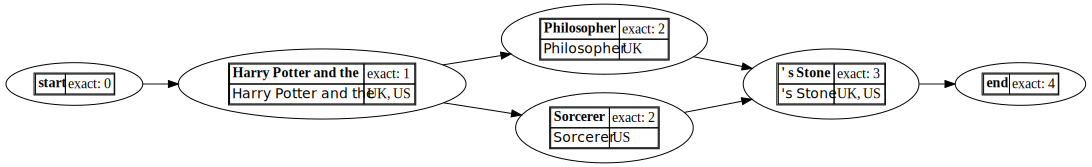

In [28]:
collate(collation, output="svg")

In this view, a text is modelled as a **directed, (acyclical) graph** and a witness is viewed as one specific **path** or **traversal** of that graph. This model of texts is becoming increasingly popular, even "hipster", in the world of digital scholarly editing and probably for good reasons -- see for instance [this abstract](https://www.balisage.net/Proceedings/vol19/print/Dekker01/BalisageVol19-Dekker01.html). Even the acts of reading and editing a text can be viewed as a traversal of this graph, that allows you to switch or **oscillate** between different witnesses.

Finally, another highly readable manner to view the results of a collation is through a coloured table. In the next code block, we collate a slightly longer portion of text. Note that this will take a while to run:

In [29]:
uk_chap = ' '.join(UK["Harry Potter and the Prisoner of Azkaban"]['Owl Post'])[:10000]
us_chap = ' '.join(US["Harry Potter and the Prisoner of Azkaban"]['OWL POST'])[:10000]

In [30]:
print(uk_chap)
print(us_chap)

Harry Potter was a highly unusual boy in many ways. For one thing, he hated the summer holidays more than any other time of year. For another, he really wanted to do his homework, but was forced to do it in secret, in the dead of night. And he also happened to be a wizard. It was nearly midnight, and he was lying on his front in bed, the blankets drawn right over his head like a tent, a torch in one hand and a large leather-bound book (A History of Magic, by Bathilda Bagshot) propped open against the pillow. Harry moved the tip of his eagle-feather quill down the page, frowning as he looked for something that would help him write his essay, ‘Witch-Burning in the Fourteenth Century Was Completely Pointless – discuss’. The quill paused at the top of a likely-looking paragraph. Harry pushed his round glasses up his nose, moved his torch closer to the book and read: Harry put his quill between his teeth and reached underneath his pillow for his ink bottle and a roll of parchment. Slowly an

In [31]:
collation = Collation()
collation.add_plain_witness('UK', uk_chap)
collation.add_plain_witness('US', us_chap)
collate(collation, layout='vertical', output='html2')

In red, this alignment table shows the segments in which the witnesses deviate. At a glance, it becomes obvious that this take on distant reading, however modest, already surfaces interesting differences in a way that would be hard to achieve using traditional means of analysis. Some categories emerge:
- The bulk of deviations are fairly straightforward differences in orthography and punctuation that are not extremely interesting from a literary point of view (`neighbours` vs `neighbors`, `toward` versus `towards`);
- A second clear categories concerns words that have been replaced by a more American expression (e.g. `torch` versus `flashlight`; `holidays` versus `break`); in many cases, however the semantics of both items is close enough to still speak of (innocent?) **synonyms**;
- A third category of changes seem to be stylistic rather then semantic. The US version replaces "stomach" with "front", for instance: in such a case, it becomes harder to speak of pure synonymy, because a front and a stomach are not the exact same thing. The same is also, and perhaps even more true for the intervention to specify or add that "Harry pushed his round glasses up *the bridge of* his nose".

The latter category of interventions are much harder to interpret, since we go beyond a simple synonym replacement as the lexical level. Why on earth would one want to change "the Dursleys" to, simply, "they" in the US version? Or add intensifying adverbs such as `particularly` or `especially` in seemindly random sentences that weren't in dire need for these additions? This category will therefore be a focal aspect of our analysis below.

### Scaling up

The previous section yieled some proof of concept that collation offer a fruitful methdology to inspect the differences between the UK and US versions at a larger scale. We are now ready to collate the entire series. However, one clear downside of the Python port is that it is much slower to run than the Java tool. In the code blocks below, we therefore first produce collations using the Java tool, which takes "only" a couple of hour to run on my laptop, whereas the Python version would have to run overnight. We dump the results as json files that we can load again later for postprocessing in Python. (You can skip the next few code blocks if you are not interested in running the actual collation yourself. We provide the dumps of the analysis so that you can with postprocessing them right away.)

In [32]:
import json
import subprocess

def java_alignment(uk_chap, us_chap):
    W = {'witnesses': [{'id': 'uk', 'content': uk_chap},
                       {'id': 'us', 'content': us_chap}]}
    
    with open('in.json', 'w') as f:
        f.write(json.dumps(W))

    subprocess.call("java -jar collatex-tools-1.7.1.jar in.json --output='out.json'", shell=True)
    
    with open('out.json', 'r') as f:
        alignment = json.loads(f.read())
    
    pairs = list(zip(*alignment['table']))
        
    uk = pairs[alignment['witnesses'].index('uk')]
    us = pairs[alignment['witnesses'].index('us')]

    return uk, us

(This takes forever.)

In [33]:
#%timeit java_alignment(uk_chap, us_chap)
#%timeit collate(collation, layout='vertical')

In [34]:
uk, us = java_alignment(uk_chap, us_chap)

In [35]:
for a, b in zip(uk, us):
    print(''.join(a), '<==>', ''.join(b))

Harry Potter was a highly unusual boy in many ways. For one thing, he hated the summer holidays more than any other time of year. For another, he really wanted to do his homework <==> Harry Potter was a highly unusual boy in many ways. For one thing, he hated the summer holidays more than any other time of year. For another, he really wanted to do his homework 
,  <==> 
but was forced to do it in secret, in the dead of night. And he also happened to be a wizard. It was nearly midnight, and he was lying on his  <==> but was forced to do it in secret, in the dead of night. And he also happened to be a wizard. It was nearly midnight, and he was lying on his 
front  <==> stomach 
in bed, the blankets drawn right over his head like a tent, a  <==> in bed, the blankets drawn right over his head like a tent, a 
torch  <==> flashlight 
in one hand and a large leather-bound book (A History of Magic <==> in one hand and a large leather-bound book (A History of Magic 
,  <==> 
by Bathilda Bagshot

Now we can ruw the collation at the chapter level in bulk and dump the results to a list of simple json-files that we can postprocess later - without having to rerun the actual collation over and over again. One important gimmick which we add at this stage is that we tokenize the texts and add a so-called **end-of-sentence marker** (EOS) in between sentences. This will help us study how and where new sentence endings have been introduced in the US version (cf. sentence length).

```python
import os
import shutil

try:
    shutil.rmtree('collations')
except FileNotFoundError:
    pass
os.mkdir('collations')

cnt = 0
for uk_book, us_book in zip(UK, US):
    print(uk_book)
    for uk_chap, us_chap in zip(UK[uk_book], US[us_book]):
        print('   ', uk_chap)
        cnt += 1
        idx = str(cnt)
        while len(idx) < 3:
            idx = '0' + idx
        
        uk_text = ' '.join(UK[uk_book][uk_chap])#[:1000]
        us_text = ' '.join(US[us_book][us_chap])#[:1000]
        
        # we add end-of-sentence (EOS) markers:
        uk_text = '<EOS> '.join(sent_tokenize(uk_text))
        us_text = '<EOS> '.join(sent_tokenize(us_text))
        
        uk, us = java_alignment(uk_text, us_text)
        
        fn = f"collations/{idx}-{uk_book.replace(' ', '_')}-{uk_chap.replace(' ', '_')}.json"
        with open(fn, 'w') as f:
            json.dump((uk, us), f)
```

## Analyzing the collation

Above, we already hinted at the possibility of establishing a simple categorization of the differences which we find between the UK and US series. Separating superficial orthographic conventions from deeper stylistic interventions, for instance, would be one clear step forward in trying to arrive at an empirical and quantitative characterization of the way in which both versions differ.

#### Synonyms
Reserving a category for "plain" synonyms, for instance, would be a relevant option. Here, one could wonder whether terms such as `pitch` and `field` are truly close enough to be considered semantically interchangable, but (as Philip Nel convincingly argues) we should not forget that such words do come with a different set of associations along both sides of the Ocean. One interesting resource to help up resolve such issues in a replicatable manner is **WordNet**. [Wordnet](https://wordnet.princeton.edu/) is a lexical resource from the fields of corpus linguistics and computational linguitics that provides a large database of words. In this gigantic tree structure, nouns, verbs, adjectives and adverbs are grouped into sets of synonyms that are called **synsets**. Each of these sets covers a distant concept and will hold, amongst other, the various synonyms that can be used to express this concept.

Below, we define a simple function that interfaces WordNet through the NLTK. When fed two words, the function will simply return whether or not it considers these words synonyms as a boolean variable that will be `True` or `False`:

In [37]:
from nltk.corpus import wordnet as wn

def is_synonym(w1, w2):
    w1 = w1.strip().lower()
    w2 = w2.strip().lower()
    synonym = False
    for synset in wn.synsets(w1):
        for lemma in synset.lemma_names():
            if lemma.lower() == w2.lower():
                synonym = True
    for synset in wn.synsets(w2):
        for lemma in synset.lemma_names():
            if lemma.lower() == w1.lower():
                synonym = True
    return synonym

Below, we try on this function on a number of word pairs. (Feel free to add a couple of pairs of your own.)

In [38]:
print(is_synonym('torch', 'flashlight'))
print(is_synonym('torch', 'dog'))
print(is_synonym('cutting', 'clipping'))
print(is_synonym('pitch', 'field'))

True
False
True
False


Note that WordNet is large, but that its coverage of the English language is far from exhaustive or perfect. Below, we will therefore consider to expand this resource with a list of our own.

#### Spelling differences

Another straightforward category to "catch" are orthographic differences between the UK and US spellings that are used fairly consistently throughout the books. In the following code we define a function that attempts to decide whether two non-identical strings are in fact just spelling differences. We do so on the basis of a long list of UK and US spelling differences which we found online.

In [39]:
uk_to_us_spellings = []
for line in open('uk_vs_us.txt', 'r'):
    if not line.strip().startswith('#'):
        uk_to_us_spellings.append(line.strip().split())

def is_spelling_diff(w1, w2):
    spelling = False
    w1 = w1.strip().lower()
    w2 = w2.strip().lower()
    
    if ''.join(OrderedDict.fromkeys(w1)) == ''.join(OrderedDict.fromkeys(w2)):
        spelling = True
    elif ''.join(w1.split()) == ''.join(w2.split()):
        spelling = True
    else:
        for british, american in uk_to_us_spellings:
            if w1.endswith(british) and w2.endswith(american):
                spelling = True
    
    return spelling

Feel to "stress test" the coverage of the function -- which seems pretty okay:

In [40]:
print(is_spelling_diff('towards', 'toward'))
print(is_spelling_diff('colour', 'color'))
print(is_spelling_diff('analyse', 'analyze'))
print(is_spelling_diff('dog', 'torch'))

True
True
True
False


We can now define a function that allows us to "score" the differences between two collated witnesses. By this, we mean that we keep track of:
1. the length of the UK chapter in characters (which we will use to normalize our counts)
2. the number of spelling modifications
3. the number of obvious synonym replacements
4. the number of "stylistic" interventions, i.e. interventions which were included in the previous two categories
5. the number of sentence boundaries introduced

In [41]:
def score_diffs(uk, us, verbose=False):
    diffs = {'len': len(uk_chap.strip()), # for normalization
             'spell': 0, 'synon': 0, 'style': 0, 'eos': 0}

    for a, b in zip(uk, us):
        if not (a is None or b is None):
            a = ''.join(a).strip().lower()
            b = ''.join(b).strip().lower()
            
            a = ''.join([c for c in a if c.isalpha() or c.isspace() or c in ('<', '>')])
            b = ''.join([c for c in b if c.isalpha() or c.isspace() or c in ('<', '>')])
            
            if a and b and a != b:
                if not '<eos>' in a and '<eos>' in b:
                    diffs['eos'] += 1
                    if verbose:
                        print(a, 'vs', b, '-> <EOS>')
                elif is_spelling_diff(a, b):
                    diffs['spell'] += 1
                    if verbose:
                        print(a, 'vs', b, '-> SPELLING')
                elif is_synonym(a, b):
                    diffs['synon'] += 1
                    if verbose:
                        print(a, 'vs', b, '-> SYNONYM')
                else:
                    diffs['style'] += 1
                    if verbose:
                        print(a, 'vs', b, '-> STYLISTIC')
    
    # normalize by the number of characters in the UK chapter
    return diffs

In [42]:
print(score_diffs(uk_chap, us_chap, verbose=True))

{'len': 20, 'spell': 0, 'synon': 0, 'style': 0, 'eos': 0}


We loop over the output of our collation and score each chapter pair. The results are stored in a so-called `pandas` **DataFrame**, a convenient way to store and query the data in a spreadsheet like fashion.

In [43]:
import pandas as pd
df = pd.DataFrame(columns=['len', 'spell', 'synon', 'style', 'book', 'chapter', 'eos'])

for fn in sorted(glob.glob('collations/*.json')):
    with open(fn, 'r') as f:
        uk, us = json.loads(f.read())
    
    score = score_diffs(uk, us, verbose=False)
    score['book'] = os.path.basename(fn).split('-')[1]
    score['chapter'] = os.path.basename(fn).split('-')[2]
        
    df = df.append(score, ignore_index=True)    

In [44]:
df

,len,spell,synon,style,book,chapter,eos
0,20,202,6,20,Harry_Potter_and_the_Philosopher's_Stone,The_Boy_Who_Lived.json,4
1,20,103,8,23,Harry_Potter_and_the_Philosopher's_Stone,The_Vanishing_Glass.json,6
2,20,155,8,23,Harry_Potter_and_the_Philosopher's_Stone,The_Letters_from_No_One.json,4
3,20,140,2,8,Harry_Potter_and_the_Philosopher's_Stone,The_Keeper_of_the_Keys.json,2
4,20,290,9,28,Harry_Potter_and_the_Philosopher's_Stone,Diagon_Alley.json,6
5,20,280,5,34,Harry_Potter_and_the_Philosopher's_Stone,The_Journey_from_Platform_Nine_and_Three,5
6,20,182,3,18,Harry_Potter_and_the_Philosopher's_Stone,The_Sorting_Hat.json,5
7,20,96,1,16,Harry_Potter_and_the_Philosopher's_Stone,The_Potions_Master.json,0
8,20,214,4,25,Harry_Potter_and_the_Philosopher's_Stone,The_Midnight_Duel.json,1
9,20,164,5,19,Harry_Potter_and_the_Philosopher's_Stone,Hallowe’en.json,1


We can easily export this dataframe to a comma-separated file format for future reference:

In [45]:
df.to_csv('align.csv')

In [46]:
df = pd.read_csv('align.csv')
df = df.infer_objects()
df['norm'] = df['style'] / df['len']
df.describe()

,Unnamed: 0,len,spell,synon,style,eos,norm
count,199.000000,199.0,199.000000,199.000000,199.000000,199.000000,199.000000
mean,99.000000,20.0,46.954774,6.175879,19.427136,12.472362,0.971357
std,57.590508,0.0,48.599611,3.900818,14.370054,8.833361,0.718503
min,0.000000,20.0,6.000000,0.000000,0.000000,0.000000,0.000000
25%,49.500000,20.0,24.000000,3.000000,9.000000,6.000000,0.450000
50%,99.000000,20.0,33.000000,6.000000,17.000000,11.000000,0.850000
75%,148.500000,20.0,46.000000,8.000000,27.000000,17.000000,1.350000
max,198.000000,20.0,290.000000,21.000000,71.000000,42.000000,3.550000


Text(0.5,0,'chapters')

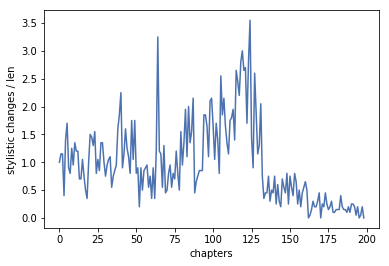

In [47]:
ax = df['norm'].plot()
ax.set_ylabel('stylistic changes / len')
ax.set_xlabel('chapters')

([<matplotlib.axis.XTick at 0x1a25e594e0>,
 <a list of 7 Text xticklabel objects>)

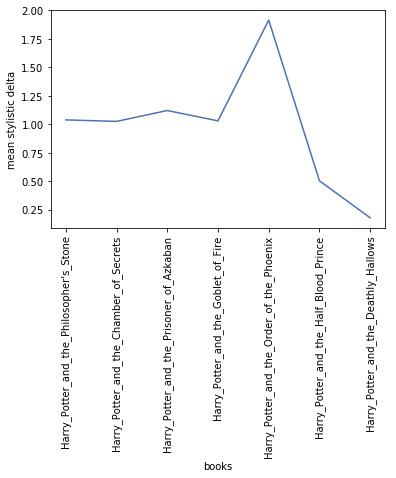

In [49]:
ax = df.groupby('book', sort=False)['norm'].mean().plot()
ax.set_ylabel('mean stylistic delta')
ax.set_xlabel('books')
t = list(df['book'].unique())
plt.xticks(range(len(t)), t, rotation='vertical')